## As stated by the datacard :

### "The primary objective of the dataset is to accurately predict incident triage grades—true positive (TP), benign positive (BP), and false positive (FP)—based on historical customer responses."

In [29]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix, classification_report, roc_auc_score, auc,roc_curve
import joblib
from IPython.display import FileLink
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from xgboost.callback import TrainingCallback

In [2]:
train = pd.read_csv("/kaggle/input/microsoft-security-incident-prediction/GUIDE_Train.csv")
test = pd.read_csv("/kaggle/input/microsoft-security-incident-prediction/GUIDE_Test.csv")

<ipython-input-2-eab9a972a746>:2: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  test = pd.read_csv("/kaggle/input/microsoft-security-incident-prediction/GUIDE_Test.csv")


## EDA Steps

1. Idenify data type mismatch (if any)
2. Dropping columns with significant proportion NULL data
3. Understanding Non-INT attributes
4. Checking if output class ratio is acceptable
5. Splitting non-int attributes, and applying label encoding
6. Visualising and trying to see other trends
7.  Training several models like logistic regression, XGBoost, Random Forest with **K FOLD CROSS VALIDATION** to understand best ML model


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9516837 entries, 0 to 9516836
Data columns (total 45 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Id                  int64  
 1   OrgId               int64  
 2   IncidentId          int64  
 3   AlertId             int64  
 4   Timestamp           object 
 5   DetectorId          int64  
 6   AlertTitle          int64  
 7   Category            object 
 8   MitreTechniques     object 
 9   IncidentGrade       object 
 10  ActionGrouped       object 
 11  ActionGranular      object 
 12  EntityType          object 
 13  EvidenceRole        object 
 14  DeviceId            int64  
 15  Sha256              int64  
 16  IpAddress           int64  
 17  Url                 int64  
 18  AccountSid          int64  
 19  AccountUpn          int64  
 20  AccountObjectId     int64  
 21  AccountName         int64  
 22  DeviceName          int64  
 23  NetworkMessageId    int64  
 24  EmailClusterId      floa

In [4]:
#Understanding which columns are missing in either csv

missing_in_test = set(train.columns) - set(test.columns)
missing_in_train = set(test.columns) - set(train.columns)

print("Missing columns in test:", missing_in_test)
print("Missing columns in train:", missing_in_train)


Missing columns in test: set()
Missing columns in train: {'Usage'}


In [5]:
print(test['Usage'][0:5])

0    Private
1     Public
2     Public
3     Public
4     Public
Name: Usage, dtype: object


In [6]:
#Checking if there is any disparity in data types

common_columns = train.columns.intersection(test.columns)

train_dtypes_common = train[common_columns].dtypes
test_dtypes_common = test[common_columns].dtypes

dtypes_diff = train_dtypes_common != test_dtypes_common

columns_with_different_dtypes = dtypes_diff[dtypes_diff].index

print("Columns with different data types:", columns_with_different_dtypes)


Columns with different data types: Index([], dtype='object')


Here is the description for the features, as mentioned in the source paper titled [**AI-Driven Guided Response for Security Operation Centers with Microsoft Copilot for Security**](https://arxiv.org/pdf/2407.09017).


| **Feature**             | **Description**                                                                 |
|-------------------------|---------------------------------------------------------------------------------|
| **Id**                  | Unique ID for each OrgId-IncidentId pair                                         |
| **OrgId**               | Organization identifier                                                          |
| **IncidentId**          | Organizationally unique incident identifier                                      |
| **AlertId**             | Unique identifier for an alert                                                   |
| **Timestamp**           | Time the alert was created                                                       |
| **DetectorId**          | Unique ID for the alert generating detector                                      |
| **AlertTitle**          | Title of the alert                                                               |
| **Category**            | Category of the alert                                                            |
| **MitreTechniques**     | MITRE ATT&CK techniques involved in alert                                        |
| **IncidentGrade**       | SOC grade assigned to the incident                                               |
| **ActionGrouped**       | SOC alert remediation action (high level)                                        |
| **ActionGranular**      | SOC alert remediation action (fine-grain)                                        |
| **EntityType**          | Type of entity involved in the alert                                             |
| **EvidenceRole**        | Role of the evidence in the investigation                                        |
| **Roles**               | Additional metadata on evidence role in alert                                    |
| **DeviceId**            | Unique identifier for the device                                                 |
| **DeviceName**          | Name of the device                                                               |
| **Sha256**              | SHA-256 hash of the file                                                         |
| **IpAddress**           | IP address involved                                                              |
| **Url**                 | URL involved                                                                     |
| **AccountSid**          | On-premises account identifier                                                   |
| **AccountUpn**          | Email account identifier                                                         |
| **AccountObjectId**     | Entra ID account identifier                                                      |
| **AccountName**         | Name of the on-premises account                                                  |
| **NetworkMessageId**    | Org-level identifier for email message                                          |
| **EmailClusterId**      | Unique identifier for the email cluster                                          |
| **RegistryKey**         | Registry key involved                                                            |
| **RegistryValueName**   | Name of the registry value                                                       |
| **RegistryValueData**   | Data of the registry value                                                       |
| **ApplicationId**       | Unique identifier for the application                                            |
| **ApplicationName**     | Name of the application                                                          |
| **OAuthApplicationId**  | OAuth application identifier                                                     |
| **ThreatFamily**        | Malware family associated with a file                                            |
| **FileName**            | Name of the file                                                                 |
| **FolderPath**          | Path of the file folder                                                          |
| **ResourceIdName**      | Name of the Azure resource                                                       |
| **ResourceType**        | Type of Azure resource                                                           |
| **OSFamily**            | Family of the operating system                                                   |
| **OSVersion**           | Version of the operating system                                                  |
| **AntispamDirection**   | Direction of the antispam filter                                                 |
| **SuspicionLevel**      | Level of suspicion                                                               |
| **LastVerdict**         | Final verdict of threat analysis                                                 |
| **CountryCode**         | Country code evidence appears in                                                 |
| **State**               | State of evidence appears in                                                     |
| **City**                | City evidence appears in                                                         |


In [7]:
# List to store columns with more than 40% null values, these shoul be dropped as they are too significantly empty
columns_with_high_null = []

total_rows = len(train) 

for column in train.columns:
    
    if train[column].isnull().sum() / total_rows > 0.4:
        columns_with_high_null.append(column)

print("Columns with more than 40% null values:", columns_with_high_null)


Columns with more than 40% null values: ['MitreTechniques', 'ActionGrouped', 'ActionGranular', 'EmailClusterId', 'ThreatFamily', 'ResourceType', 'Roles', 'AntispamDirection', 'SuspicionLevel', 'LastVerdict']


In [8]:
train = train.drop(columns=columns_with_high_null)
test = test.drop(columns=columns_with_high_null)

In [9]:
print(f"total_rows:  {total_rows}")
train[['Id','OrgId','DetectorId','Sha256','DetectorId','IpAddress','Url','AccountSid']].nunique()

total_rows:  9516837


Id            730778
OrgId           5769
DetectorId      8428
Sha256        106416
DetectorId      8428
IpAddress     285957
Url           123252
AccountSid    358401
dtype: int64

In [10]:
for column in train.select_dtypes([object]):
    unique_values = train[column].unique()
    print(f"Column: {column}")
    print(f"3 Unique Values: {unique_values[:3]}")
    print(f"Number of unique values: {len(unique_values)}")
    print(f"Number of NULL values: {train[column].isnull().sum()}")
    print("-" * 30)


Column: Timestamp
3 Unique Values: ['2024-06-04T06:05:15.000Z' '2024-06-14T03:01:25.000Z'
 '2024-06-13T04:52:55.000Z']
Number of unique values: 760944
Number of NULL values: 0
------------------------------
Column: Category
3 Unique Values: ['InitialAccess' 'Exfiltration' 'CommandAndControl']
Number of unique values: 20
Number of NULL values: 0
------------------------------
Column: IncidentGrade
3 Unique Values: ['TruePositive' 'FalsePositive' 'BenignPositive']
Number of unique values: 4
Number of NULL values: 51340
------------------------------
Column: EntityType
3 Unique Values: ['Ip' 'User' 'Url']
Number of unique values: 33
Number of NULL values: 0
------------------------------
Column: EvidenceRole
3 Unique Values: ['Related' 'Impacted']
Number of unique values: 2
Number of NULL values: 0
------------------------------


In [11]:
#We have to delete the entries with missing Incident Grade as we cannot randomly assign a label to the output class

train = train.dropna(subset=['IncidentGrade'])

null_counts = train.isnull().sum()
non_zero_nulls = null_counts[null_counts > 0]
print(non_zero_nulls)

Series([], dtype: int64)


In [12]:
# Processing DateTime
unique_lengths = set(train['Timestamp'].map(len))
print(unique_lengths)

train['Timestamp'] = pd.to_datetime(train['Timestamp'])

train['Year'] = train['Timestamp'].dt.year
train['Month'] = train['Timestamp'].dt.month
train['Day'] = train['Timestamp'].dt.day
train['Hour'] = train['Timestamp'].dt.hour
train['Minute'] = train['Timestamp'].dt.minute
train['Second'] = train['Timestamp'].dt.second
train['Weekday'] = train['Timestamp'].dt.weekday  # 0 = Monday, 6 = Sunday


test['Timestamp'] = pd.to_datetime(test['Timestamp'])

test['Year'] = test['Timestamp'].dt.year
test['Month'] = test['Timestamp'].dt.month
test['Day'] = test['Timestamp'].dt.day
test['Hour'] = test['Timestamp'].dt.hour
test['Minute'] = test['Timestamp'].dt.minute
test['Second'] = test['Timestamp'].dt.second
test['Weekday'] = test['Timestamp'].dt.weekday 

{24}


In [13]:
print("Unique values for Year:", len(train['Year'].unique()))

#Thus we cant delete year as there's more than 1 

Unique values for Year: 2


In [14]:
train.select_dtypes([int]).columns

Index(['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'AlertTitle',
       'DeviceId', 'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn',
       'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId',
       'RegistryKey', 'RegistryValueName', 'RegistryValueData',
       'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 'FileName',
       'FolderPath', 'ResourceIdName', 'OSFamily', 'OSVersion', 'CountryCode',
       'State', 'City', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'Second',
       'Weekday'],
      dtype='object')

None of these can be normalised

In [15]:
#label_encoding

to_label_encode = train.select_dtypes([object]).columns

print(to_label_encode)

label_encoders = {}

for col in to_label_encode:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])  
    label_encoders[col] = le 

for col in to_label_encode:
    if col in test: 
        test[col] = label_encoders[col].transform(test[col]) 

Index(['Category', 'IncidentGrade', 'EntityType', 'EvidenceRole'], dtype='object')


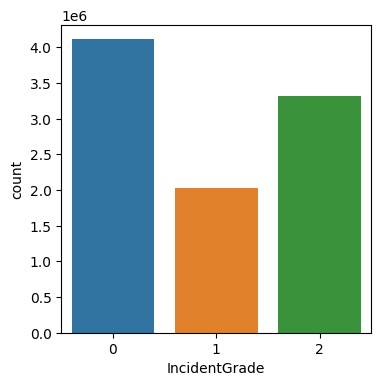

In [16]:
plt.figure(figsize=(4,4))
sns.countplot(x ='IncidentGrade', data = train)
plt.show()

#No output class is very small compared to others, so need to adding duplicates

In [17]:
#Sha256 is same as filename, so no  need to keep it, timestamp has been processed
train = train.drop(['Timestamp', 'Sha256'], axis=1)
test = test.drop(['Timestamp', 'Sha256'], axis=1)

In [18]:
correlation_matrix = train.corr()

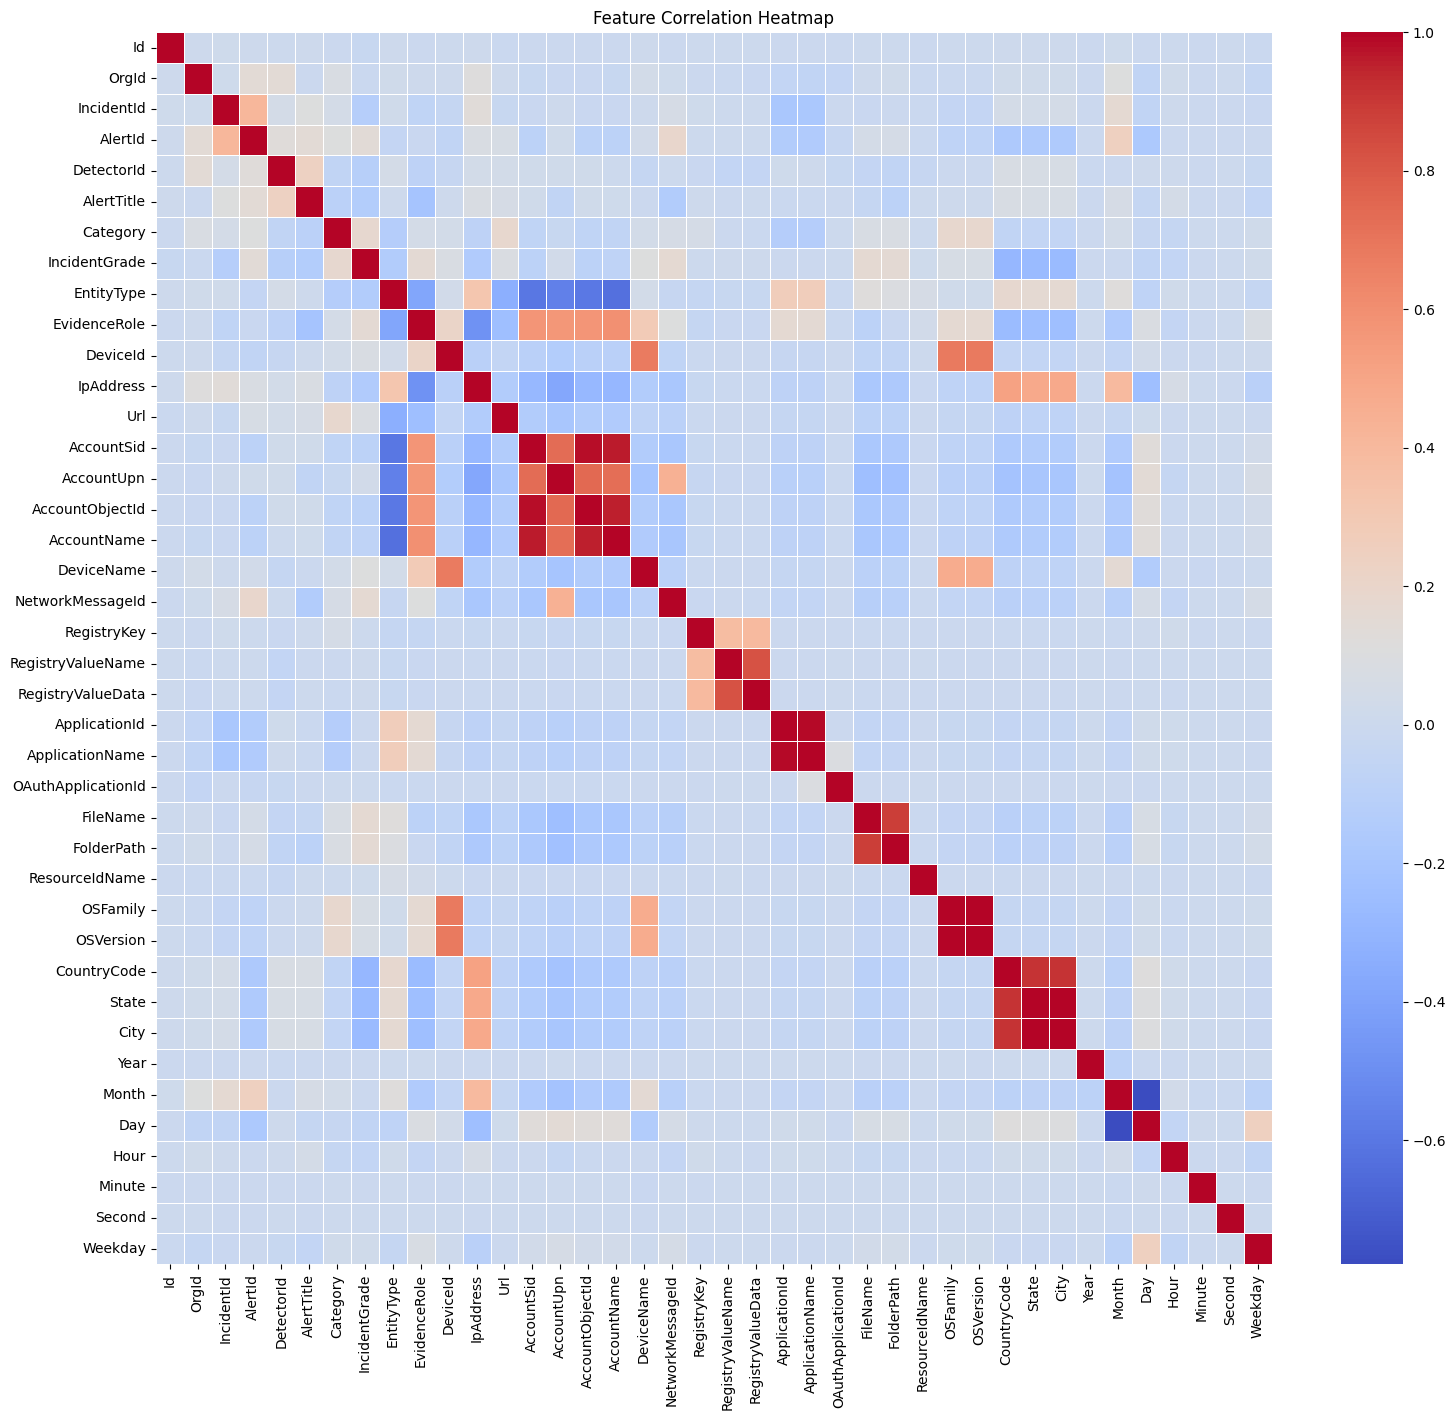

In [19]:
# Visualize correlation heatmap
plt.figure(figsize=(18, 16))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

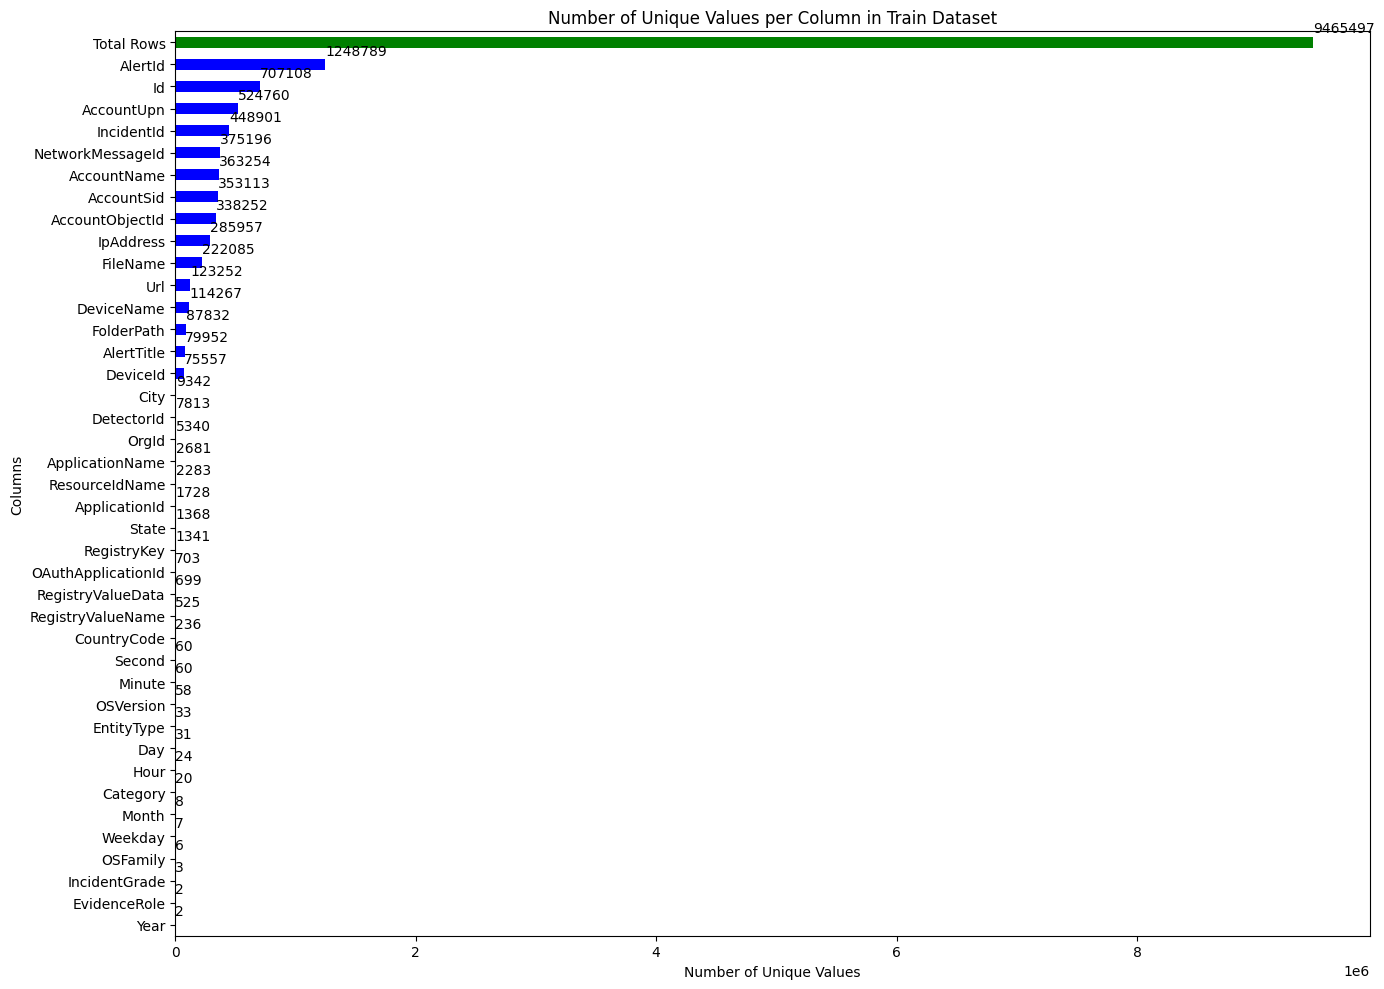

In [20]:
unique_counts = train.nunique()
unique_counts["Total Rows"] = len(train) 

plt.figure(figsize=(14, 10))
ax = unique_counts.sort_values().plot(kind="barh", color=['blue' if c != "Total Rows" else 'green' for c in unique_counts.index])
plt.title("Number of Unique Values per Column in Train Dataset")
plt.ylabel("Columns")
plt.xlabel("Number of Unique Values")

for p in ax.patches:
    ax.annotate(str(p.get_width()), (p.get_width() + 5, p.get_y() + p.get_height() / 2.),
                va='center', xytext=(0, 10), textcoords='offset points')

plt.tight_layout()
plt.show()


In [21]:
# train.columns = list(train.columns)

# num_columns = len(train.columns)
# num_cols = 2  
# num_rows = (num_columns + 1) // num_cols 

# fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 6 * num_rows))
# axes = axes.flatten()  


# for i, column in enumerate(train.columns):
#     ax = axes[i]
#     sns.countplot(data=train, x=column, ax=ax)
#     ax.set_xlabel(column)
#     ax.set_ylabel('Count')
#     ax.set_title(f'Count Plot for {column}')
#     ax.tick_params(axis='x', rotation=45) 

# for i in range(num_columns, len(axes)):
#     axes[i].axis('off')

# plt.tight_layout()
# plt.show()


In [22]:
X_train = train.drop(columns=['IncidentGrade'])
y_train = train['IncidentGrade']

X_test = test.drop(columns=['IncidentGrade','Usage'])
y_test = test['IncidentGrade']

## We now check which model is best using various parameters, and choose best model. We use **k fold cross validation for enhanced reliability and uniformity**

In [23]:
# param_grids = {
#     "Logistic Regression": {
#         "C": np.logspace(-2, 2, 10),  
#         "penalty": ["l2"], 
#         "solver": ["lbfgs"], 
#         "multi_class": ["multinomial"]
#     },
#     "XGBoost": {
#         "learning_rate": np.linspace(0.01, 0.3, 10),  
#         'n_estimators': list(range(50, 500, 50)),  
#         'max_depth': list(range(5, 25)),  
#         "subsample": [0.6, 0.8, 1.0], 
#         "colsample_bytree": [0.6, 0.8, 1.0],  
#         "reg_lambda": [0, 0.1, 1.0],  
#         "objective": ["multi:softmax"],  
#         "num_class": [3]  
#     },
#     "Random Forest": {
#         'n_estimators':list(range(50, 500, 50)),  
#         'max_depth': list(range(5, 25)),   
#         'min_samples_split': list(range(2, 20, 2)), 
#         'min_samples_leaf': list(range(1, 10, 2)), 
#         'max_features': ["sqrt", "log2", None]  
#     }
# }

param_grids = {
    "Logistic Regression": {
        "C": [0.1, 1.0, 10.0],  # Just 3 key values
        "penalty": ["l2"],
        "solver": ["lbfgs"],
        "multi_class": ["multinomial"]
    },
    "XGBoost": {
        "learning_rate": [0.1, 0.3],  # Most common effective values
        'n_estimators': [100, 200],  # Reasonable tree counts
        'max_depth': [5, 10, 15],  # Common depth ranges
        "subsample": [0.8],  # Just one common good value
        "colsample_bytree": [0.8],  # Just one common good value
        "reg_lambda": [1.0],  # Default value
        "objective": ["multi:softmax"],
        "num_class": [3]
    },
    "Random Forest": {
        'n_estimators': [100, 200],  # Reasonable tree counts
        'max_depth': [10, 15],  # Common depth values
        'min_samples_split': [2, 5],  # Common split thresholds
        'min_samples_leaf': [1, 3],  # Common leaf sizes
        'max_features': ["sqrt"]  # Most commonly used
    }
}


models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000, multi_class="multinomial"),  
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss', objective="multi:softmax", num_class=3),
    "Random Forest": RandomForestClassifier(random_state=42)
}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [24]:
# best_models = {}

# for model_name, model in models.items():
#     print(f"\nTraining and Evaluating: {model_name}")
    
#     param_grid = param_grids[model_name]
    
#     grid_search = GridSearchCV(model, param_grid, cv=kf, scoring='neg_log_loss', verbose=3, n_jobs=2)
#     grid_search.fit(X_train, y_train)  # This will perform K-Fold CV internally

#     best_model = grid_search.best_estimator_
    
#     print("Best Parameters:", grid_search.best_params_)
    
#     y_pred_test = best_model.predict(X_test)
#     test_loss = log_loss(y_test, best_model.predict_proba(X_test))
#     test_acc = accuracy_score(y_test, y_pred_test)
    
#     y_pred_train = best_model.predict(X_train)
#     train_loss = log_loss(y_train, best_model.predict_proba(X_train))
#     train_acc = accuracy_score(y_train, y_pred_train)
    
#     print(f"🔹 Testing Accuracy: {test_acc:.4f}")
#     print(f"🔹 Testing Log Loss: {test_loss:.4f}")
#     print(f"🔹 Training Accuracy: {train_acc:.4f}")
#     print(f"🔹 Training Log Loss: {train_loss:.4f}")
    
#     # Store results for later comparison
#     best_models[model_name] = {
#         "Best Model": best_model,
#         "Best Parameters": grid_search.best_params_,
#         "Test Accuracy": test_acc,
#         "Test Log Loss": test_loss
#     }

# # Find the best performing model (lowest test log loss)
# best_model_name = min(best_models, key=lambda k: best_models[k]["Test Log Loss"])
# print(f"\n🔥 Best Model: {best_model_name} with parameters {best_models[best_model_name]['Best Parameters']}\nTest Accruacy:{best_models[best_model_name]['Test Accuracy']}")
# best_model = best_models[best_model_name]["Best Model"]


# [SCREENSHOT WITH BEST ACCURACY AND PARAMTERS](https://drive.google.com/uc?id=148nNGvEGRzhOus5BbsFIm5dmmpUJUxxm)
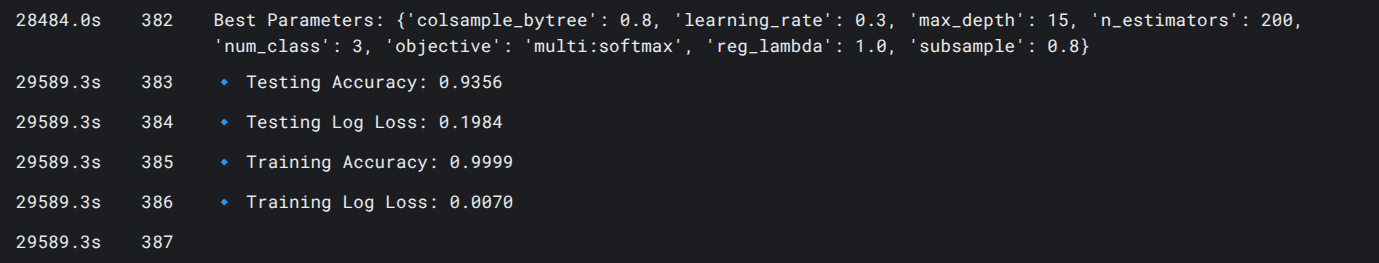
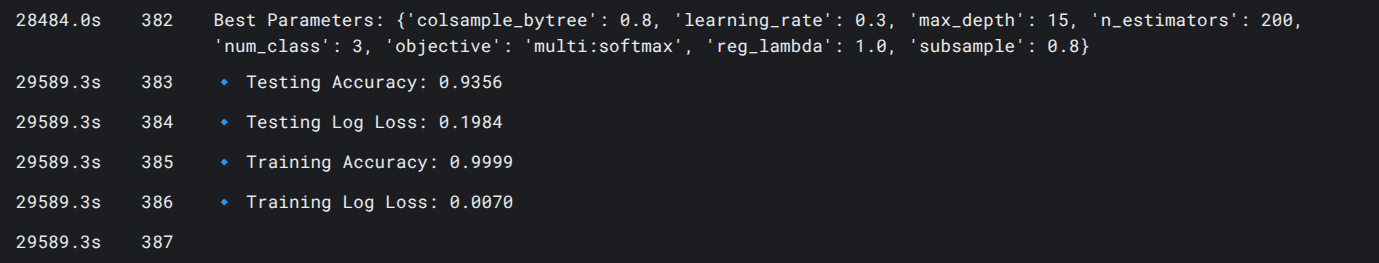

In [30]:
class CustomCallback(TrainingCallback):
    def after_iteration(self, model, epoch, evals_log):
        print(f"Epoch {epoch}: {evals_log}")
        return False

In [33]:
best_params = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.3,
    'max_depth': 15,
    'n_estimators': 200,
    'num_class': 3,
    'objective': 'multi:softmax',
    'reg_lambda': 1.0,
    'subsample': 0.8
}

best_model = XGBClassifier(**best_params, verbosity=2)
best_model.fit(X_train, y_train,verbose = True)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None, num_class=3,
              num_parallel_tree=None, ...)

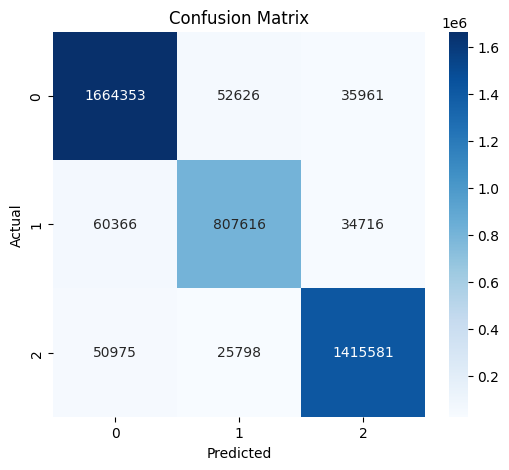

NameError: name 'best_model_name' is not defined

In [35]:
y_pred_test = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix")
plt.show()

In [36]:
print(f"\nClassification Report:\n")
print(classification_report(y_test, y_pred_test))


Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.95      0.94   1752940
           1       0.91      0.89      0.90    902698
           2       0.95      0.95      0.95   1492354

    accuracy                           0.94   4147992
   macro avg       0.93      0.93      0.93   4147992
weighted avg       0.94      0.94      0.94   4147992



In [37]:
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
y_score = best_model.predict_proba(X_test)

if len(np.unique(y_test)) > 1:
    auc_scores = roc_auc_score(y_test_bin, y_score, average=None)
    for i, cls in enumerate(np.unique(y_test)):
        print(f"AUC for class {cls}: {auc_scores[i]:.4f}")
else:
    print("AUC-ROC cannot be computed because only one class is present in y_test.")


AUC for class 0: 0.9909
AUC for class 1: 0.9878
AUC for class 2: 0.9943


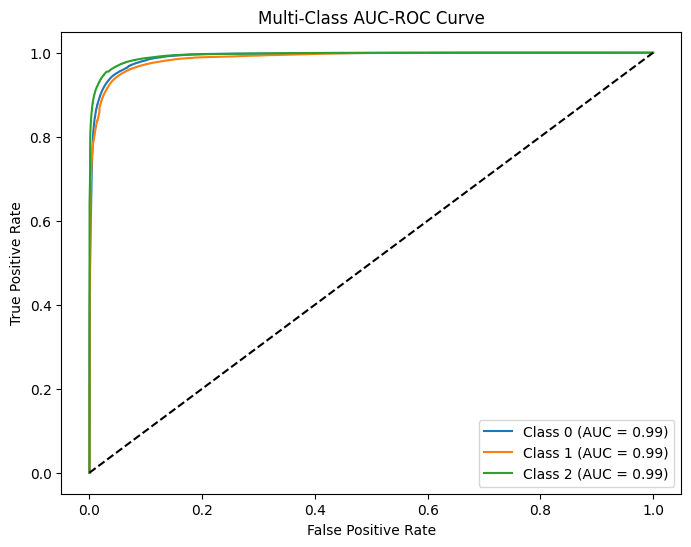

In [38]:
plt.figure(figsize=(8,6))
for i, cls in enumerate(best_model.classes_):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {cls} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"Multi-Class AUC-ROC Curve")
plt.legend(loc="lower right")
plt.show()

In [41]:
print("Test accuracy:",accuracy_score(y_test, y_pred_test) * 100 )

Test accuracy: 93.721251149954


### Further steps:

- It may be beneficial to check if a Neural Network is also trained for further comparison
- Other test and train data should be presented to check if **overfitting** has occured


Overall this is a step by which we can identify based on attributes, what the IncidentGrade is.